# Single cell querying
March 2024

Vyom Raval

Make sure your docker container is running with the terminal command `docker compose up -d`

We are using Samarjit's datajoint repo, so make sure to pull it and include the path below.

In [1]:
samarjit_dj_api = '/Users/riekelabbackup/Desktop/Vyom/gitrepos/samarjit_datajoint/next-app/api/'
import sys
sys.path.append(samarjit_dj_api)
import schema
import helpers.pop as pop
import importlib
importlib.reload(pop)

[2025-05-08 12:02:32,600][INFO]: Connecting root@127.0.0.1:3306
[2025-05-08 12:02:32,730][INFO]: Connected root@127.0.0.1:3306


<module 'helpers.pop' from '/Users/riekelabbackup/Desktop/Vyom/gitrepos/samarjit_datajoint/next-app/api/helpers/pop.py'>

I ran the following to create JSON from Fred's h5:

`python parse_data.py '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data/2024-10-16_E.h5' '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/2024-10-16_E.json'`

In [2]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import h5py

import pandas as pd
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp
import djutils as dju

Let's connect to the datajoint server hosted in our docker container.

In [3]:
host_address, user, password = '127.0.0.1', 'root', 'simple'
dj.config["database.host"] = f"{host_address}"
dj.config["database.user"] = f"{user}"
dj.config["database.password"] = f"{password}"
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

Define paths to data, and load in any new data. Particularly interested in loading the new single cell h5 file.

In [ ]:
db = dj.VirtualModule('schema.py', 'schema')
data_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data'
# data_dir = '/Volumes/data-1/data/h5'
meta_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta'
tags_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags'
username = 'vyomr'
pop.append_data(data_dir, meta_dir, tags_dir, username, db)

Pull out epoch level data

In [ ]:
# get_epoch_data returns a dataframe with all the epochs for a given experiment, and a summary dataframe
df, df_summary = dju.get_epoch_data_from_exp('2024-10-16_E')
df_summary

,cell_type,cell_id,protocol_name,num_epochs
0,RGC\OFF-parasol,124,FlashedSpotModSurround,924
1,RGC\OFF-parasol,124,ExpandingSpots,48
2,RGC\OFF-parasol,125,FlashedSpotModSurround,756
3,RGC\OFF-parasol,125,ExpandingSpots,50
4,RGC\ON-parasol,126,FlashedSpotModSurround,632
5,RGC\ON-parasol,126,ExpandingSpots,56
6,RGC\ON-parasol,126,SplitFieldCentering,6
7,RGC\ON-parasol,129,FlashedSpotModSurround,618
8,RGC\ON-parasol,130,FlashedSpotModSurround,672
9,RGC\ON-parasol,130,ExpandingSpots,58


In [29]:
df_summary['cell_id'].nunique()

8

In [ ]:
for cell_type in df_summary['cell_type'].unique():
    print(f"{cell_type}: {df_summary[df_summary['cell_type'] == cell_type]['cell_id'].nunique()}")

RGC\OFF-parasol: 2
RGC\ON-parasol: 4
bipolar\ON-diffuse: 1
horizontal: 1


So we have 8 unique cells. 2 OffP, 4 OnP, 1 horizontal, 1 On diffuse.

Let's get 'DovesMoviePlusLinearEquiv' protocol for our 1 horizontal cell, pulling raw data traces from the h5

In [23]:
str_protocol_search = 'DovesMoviePlusLinearEquiv'
ls_params = ['stimulusIndex']
str_h5 = '/Volumes/Vyom MEA/data/samarjit_datajoint/test/data/2024-10-16_E.h5'
dvs_h_data = dju.construct_patch_data(df, str_protocol=str_protocol_search, cell_id=127,
                                      ls_params=ls_params, str_h5=str_h5, b_spiking=False)

Found 48 trials for DovesMoviePlusLinearEquiv and cell 127
Shape of data: Amp1: (48, 67500), Frame Monitor: (48, 67500)
Sample rate: Amp1: 10000.0 Hz, Frame Monitor: 10000.0 Hz
Detecting frame flips...
Found unique frame rates: [59.49636328 59.94274126]


So we have 48 trials x 67500 samples of data (i.e. 6.75s at 10kHz)

In [11]:
dvs_h_data._fields

('data',
 'frame_data',
 'frame_times',
 'frame_rates',
 'sample_rate',
 'params',
 'u_params')

In [ ]:
# Unique params
dvs_h_data.u_params

{'stimulusIndex': array([ 2.,  6., 12., 30., 40., 50.]),
 'preTime': array([250.]),
 'stimTime': array([6000.]),
 'tailTime': array([500.])}

Let's plot the data for the 8 trials with the first unique stimulus.

Text(0.5, 1.0, 'Horizontal cell responses to stimulus index 2.0')

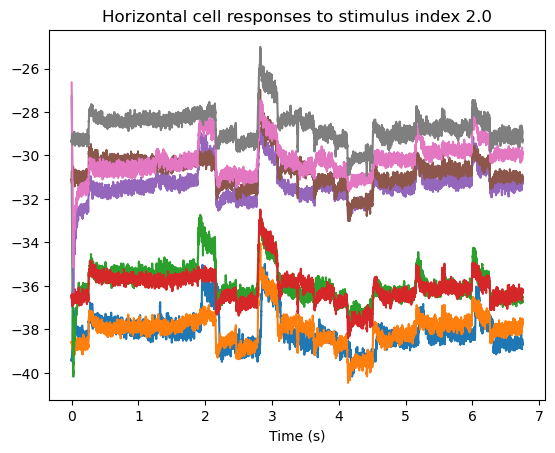

In [20]:
u_stim_idx = 0
stim_idx = dvs_h_data.u_params['stimulusIndex'][u_stim_idx]
all_stim_idx = dvs_h_data.params['stimulusIndex']

trials = np.where(all_stim_idx==stim_idx)[0]

n_samples = dvs_h_data.data.shape[1]

time = np.arange(0, n_samples/dvs_h_data.sample_rate, 1/dvs_h_data.sample_rate)
for i in trials:
    plt.plot(time, dvs_h_data.data[i, :])
plt.xlabel('Time (s)')
plt.title(f'Horizontal cell responses to stimulus index {stim_idx}')

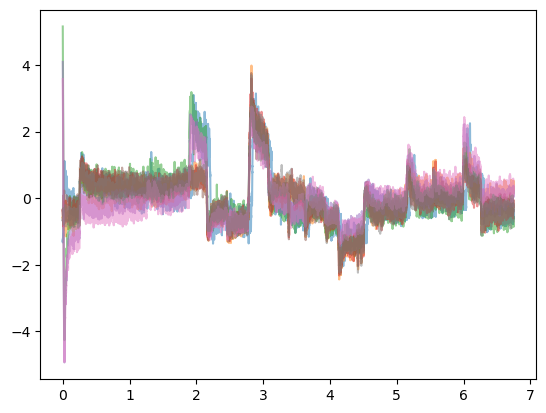

In [34]:
# Subtracting trial mean
for i in trials:
    trace = dvs_h_data.data[i, :]
    trace = trace - trace.mean()
    plt.plot(time, trace, alpha=0.5)